In [1]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from utils.Dataset import load_logging_data, create_lstm_dataset
from utils.ForecastModel import lstm_est_model_v2
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

In [2]:
train_dataset = load_logging_data(data_root_path='data/train')
val_dataset = load_logging_data(data_root_path='data/val')

Loading data...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading data...:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
angle_name_list = list(train_dataset.columns)[22:24] + list(train_dataset.columns)[26:28]
pressure_name_list = list(train_dataset.columns)[18:20] + list(train_dataset.columns)[24:26]

In [4]:
train_dataset['power'] = train_dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] * train_dataset['caloutput_rotate_velocity CH=25']
train_dataset = train_dataset[['pressure_1_pressure_transmitter_1_drive1 CH=23']+angle_name_list+['caloutput_rotate_velocity CH=25', 'caloutput_drill_depth CH=26', 'power']]
train_dataset.describe()

#for angle_name in angle_name_list:
#    dataset = dataset[dataset[angle_name] < 30]

#for angle_name in angle_name_list:
#    dataset = dataset[dataset[angle_name] > -30]

#dataset.reset_index(drop=True, inplace=True)

for angle_name in angle_name_list:
    train_dataset[angle_name] = train_dataset[angle_name]/33

train_dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] = train_dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] / 256
train_dataset['caloutput_rotate_velocity CH=25'] = train_dataset['caloutput_rotate_velocity CH=25'] / 50
train_dataset['caloutput_drill_depth CH=26'] = train_dataset['caloutput_drill_depth CH=26'] / 31
train_dataset['power'] = train_dataset['power']/4100

In [5]:
train_dataset.describe()

,pressure_1_pressure_transmitter_1_drive1 CH=23,angle_Mast_X CH=27,angle_Mast_Y CH=28,angle_base_X CH=31,angle_base_Y CH=32,caloutput_rotate_velocity CH=25,caloutput_drill_depth CH=26,power
count,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000,15994.000000,1.599400e+04,15994.000000
mean,0.314883,-3.781705,-3.817823,-3.808247,-3.784141,0.125287,9.677419e-02,0.130005
std,0.112485,338.851212,338.850808,338.850915,338.851184,0.135315,1.387822e-17,0.135261
min,0.075586,-30303.030303,-30303.030303,-30303.030303,-30303.030303,0.000000,9.677419e-02,0.000000
25%,0.276875,0.003030,-0.033333,-0.021212,0.003030,0.000000,9.677419e-02,0.000000
50%,0.306055,0.009091,-0.024242,-0.021212,0.003030,0.100000,9.677419e-02,0.093902
75%,0.353711,0.012121,-0.021212,-0.018182,0.006061,0.200000,9.677419e-02,0.225659
max,0.997461,0.993939,-0.003030,0.054545,0.042424,1.000000,9.677419e-02,0.996905


In [6]:
val_dataset['power'] = val_dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] * val_dataset['caloutput_rotate_velocity CH=25']
val_dataset = val_dataset[['pressure_1_pressure_transmitter_1_drive1 CH=23']+angle_name_list+['caloutput_rotate_velocity CH=25', 'caloutput_drill_depth CH=26', 'power']]
val_dataset.describe()

#for angle_name in angle_name_list:
#    dataset = dataset[dataset[angle_name] < 30]

#for angle_name in angle_name_list:
#    dataset = dataset[dataset[angle_name] > -30]

#dataset.reset_index(drop=True, inplace=True)

for angle_name in angle_name_list:
    val_dataset[angle_name] = val_dataset[angle_name]/33

val_dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] = val_dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] / 256
val_dataset['caloutput_rotate_velocity CH=25'] = val_dataset['caloutput_rotate_velocity CH=25'] / 50
val_dataset['caloutput_drill_depth CH=26'] = val_dataset['caloutput_drill_depth CH=26'] / 31
val_dataset['power'] = val_dataset['power']/4100

In [7]:
val_dataset.describe()

,pressure_1_pressure_transmitter_1_drive1 CH=23,angle_Mast_X CH=27,angle_Mast_Y CH=28,angle_base_X CH=31,angle_base_Y CH=32,caloutput_rotate_velocity CH=25,caloutput_drill_depth CH=26,power
count,5379.000000,5379.000000,5379.000000,5379.000000,5379.000000,5379.000000,5379.000000,5379.000000
mean,0.270336,-5.625733,-5.650531,-5.653428,-5.648000,0.122339,0.504639,0.127824
std,0.125998,413.176298,413.175961,413.175921,413.175995,0.153802,0.367867,0.159114
min,0.075586,-30303.030303,-30303.030303,-30303.030303,-30303.030303,0.000000,-0.032258,0.000000
25%,0.205391,0.006061,-0.021212,-0.021212,-0.018182,0.000000,0.161290,0.000000
50%,0.271602,0.009091,-0.015152,-0.021212,-0.015152,0.060000,0.451613,0.056341
75%,0.327266,0.009091,-0.009091,-0.018182,-0.012121,0.220000,0.903226,0.214146
max,0.772266,0.069697,0.027273,0.006061,0.003030,0.800000,1.000000,0.736529


In [8]:
train_extract_dataset = train_dataset[['pressure_1_pressure_transmitter_1_drive1 CH=23']+angle_name_list+['caloutput_rotate_velocity CH=25', 'caloutput_drill_depth CH=26', 'power']]
val_extract_dataset = val_dataset[['pressure_1_pressure_transmitter_1_drive1 CH=23']+angle_name_list+['caloutput_rotate_velocity CH=25', 'caloutput_drill_depth CH=26', 'power']]

In [9]:
seq_len = 30
pred_distance = 10
hidden_size = 512
n_output = 1

train_feature, train_target = create_lstm_dataset(train_extract_dataset.values, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=7)
val_feature, val_target = create_lstm_dataset(val_extract_dataset.values, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=7)

In [10]:
print(train_feature.shape, train_target.shape)
print(val_feature.shape, val_target.shape)

(15955, 30, 8) (15955,)
(5340, 30, 8) (5340,)


In [11]:
bool_idx = val_target!=0

<Axes: ylabel='Count'>

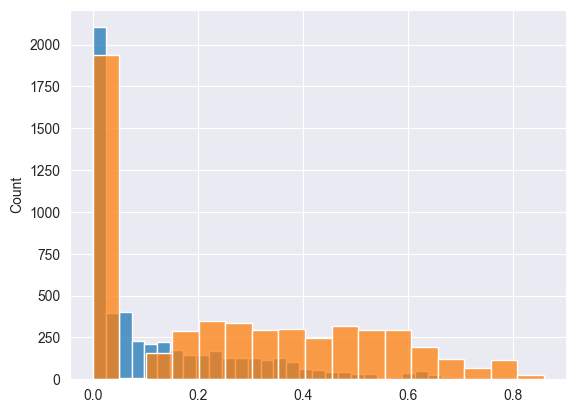

In [12]:
sns.histplot(val_target, label='target')
sns.histplot(np.sqrt(val_target), label='sqrt(target)')

<Axes: ylabel='Count'>

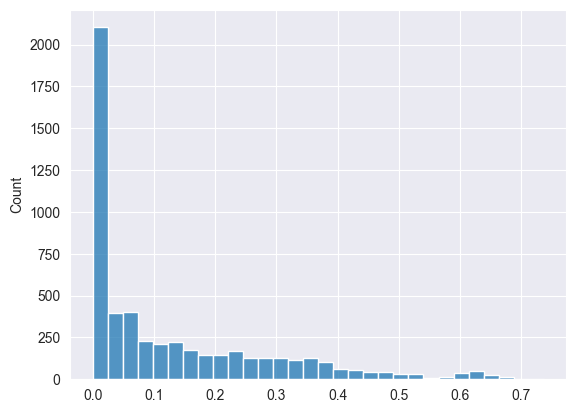

In [13]:
sns.histplot(np.square(np.sqrt(val_target)), label='log(target)')

In [14]:
train_bool_idx = train_target!=0
val_bool_idx = val_target!=0

train_feature = train_feature
train_target = np.sqrt(train_target)

val_feature = val_feature
val_target = np.sqrt(val_target)

In [15]:
lstm_model = lstm_est_model_v2(input_tensor=train_feature, seq_len=seq_len, hidden_size=hidden_size)
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 8)]           0         
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            800       
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 64)            6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 128)           24704     
                                                                 
 lstm (LSTM)                 (None, 512)               1312768   
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 1,344,993
Trainable params: 1,344,993
Non-train

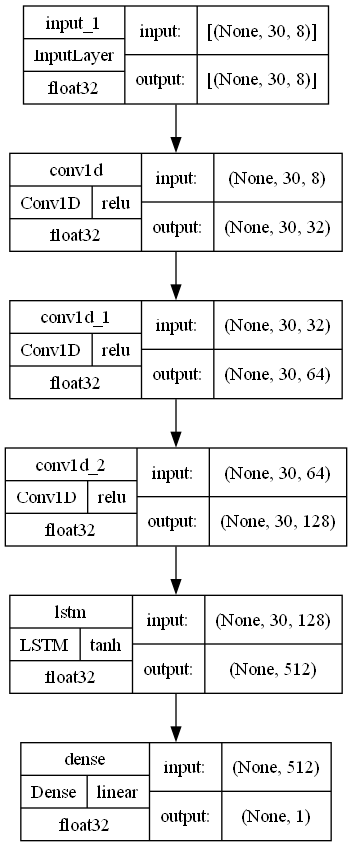

In [16]:
keras.utils.plot_model(lstm_model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)

In [17]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, verbose=0)
csv_logger = keras.callbacks.CSVLogger(filename='log_'+str(pred_distance)+'.csv', append=False, separator=',')
model_chk_point = keras.callbacks.ModelCheckpoint(filepath='model_'+str(pred_distance)+'.keras', monitor="val_loss", verbose=0,
                                                      save_best_only=True, save_weights_only=False, mode="min", save_freq="epoch",
                                                      initial_value_threshold=None)

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f'_pred_distance_{pred_distance}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [18]:
train_bool_idx = train_target!=0
val_bool_idx = val_target!=0

lstm_model.fit(x=train_feature, y=train_target, validation_data=(val_feature, val_target), epochs=10000000,
               batch_size=10000, verbose=0, callbacks=[early_stop, csv_logger, model_chk_point, tensorboard_callback])

In [19]:
best_lstm_model = keras.models.load_model(f'model_{pred_distance}.keras')
model_log = pd.read_csv(f'log_{pred_distance}.csv')

In [20]:
pred = np.squeeze(best_lstm_model.predict(val_feature, verbose=1))
#pred = np.square(pred)
for i, val in enumerate(pred):
    if val < 0:
        pred[i] = 0

pd.DataFrame(pred).describe()

167/167 [==============================] - 1s 4ms/step


,0
count,5340.000000
mean,0.261848
std,0.236995
min,0.000000
25%,0.038673
50%,0.183298
75%,0.457139
max,0.903978


In [21]:
print(r2_score(val_target, pred))
print(mean_absolute_error(val_target, pred))
print(mean_absolute_percentage_error(val_target, pred))

0.907649427568601
0.057702673659663195
71883064877307.7


<Axes: >

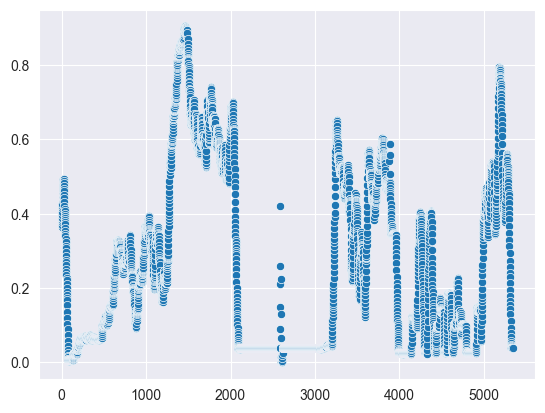

In [22]:
sns.scatterplot(pred)

Text(0, 0.5, 'Loss')

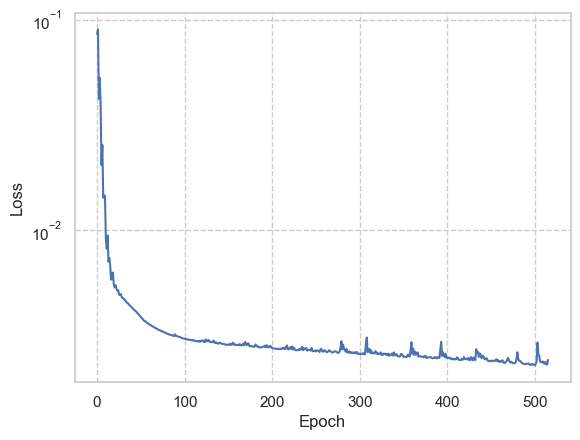

In [23]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(data=model_log, x='epoch', y='loss')

#plt.xlim(0, 3000)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.legend(['Train Loss', 'Validation Loss'])

Text(0, 0.5, 'Mean Absolute Error')

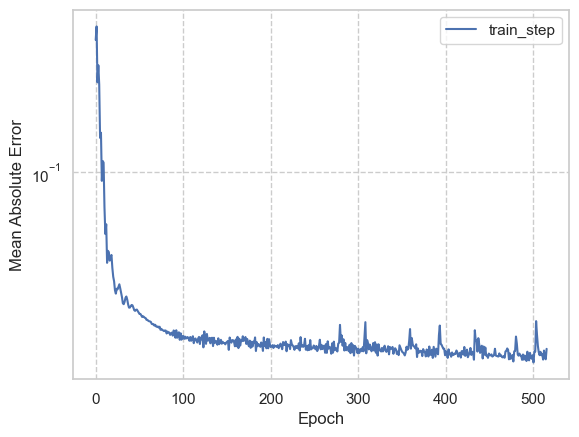

In [24]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(data=model_log, x='epoch', y='mean_absolute_error', label='train_step')

#plt.xlim(0, 3000)
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Mean Absolute Error')

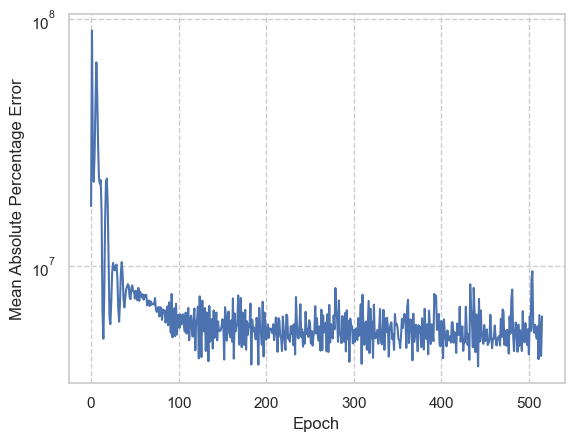

In [25]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(data=model_log, x='epoch', y='mean_absolute_percentage_error')

#plt.xlim(0, 3000)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Percentage Error')
plt.yscale('log')
#plt.legend(['Train Loss', 'Validation Loss'])

Text(0, 0.5, 'power')

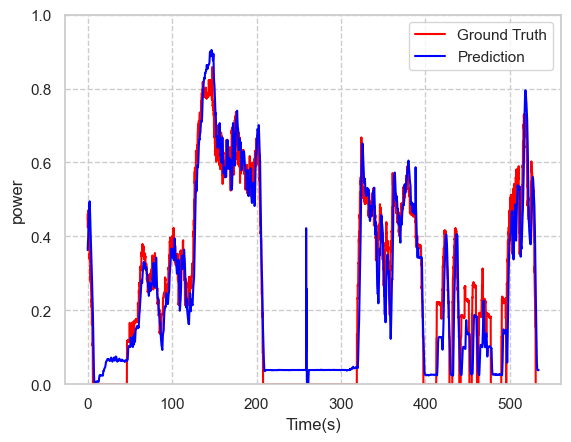

In [26]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(x=np.arange(val_target.shape[0])/10, y=val_target, label='Ground Truth', color='red', linewidth=1.5)
sns.lineplot(x=np.arange(pred.shape[0])/10, y=pred, label='Prediction', color='blue')

#plt.xlim(120, 140)
plt.xlabel('Time(s)')
plt.ylim(0, 1)
plt.ylabel('power')

<Axes: >

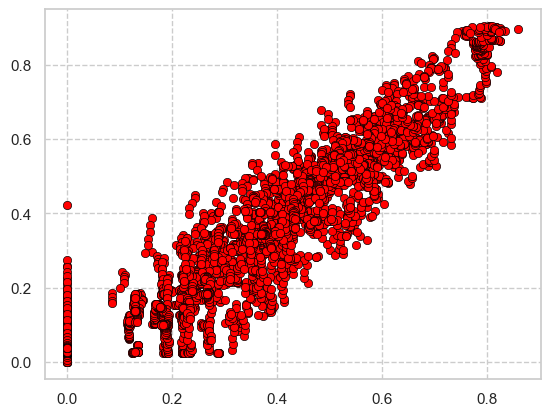

In [27]:
sns.scatterplot(x=val_target, y=pred, color='red', edgecolor='black')

15938.457539130404

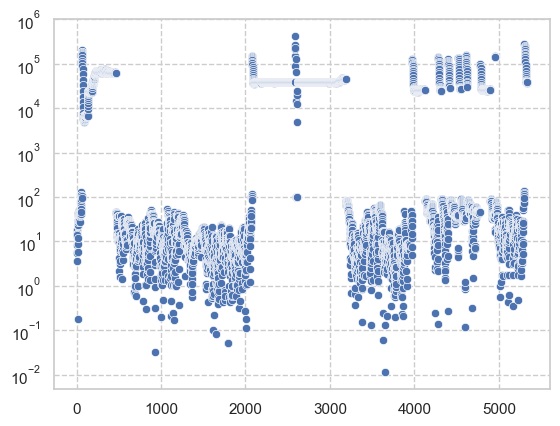

In [28]:
new_target = []

for i, val in enumerate(val_target):
    if val > 0:
       new_target.append(val_target[i])
    else:
        new_target.append(0.0001)

error = (np.abs(new_target-pred)/new_target)*100

sns.scatterplot(error)

plt.yscale('log')

np.mean(error)

<Axes: >

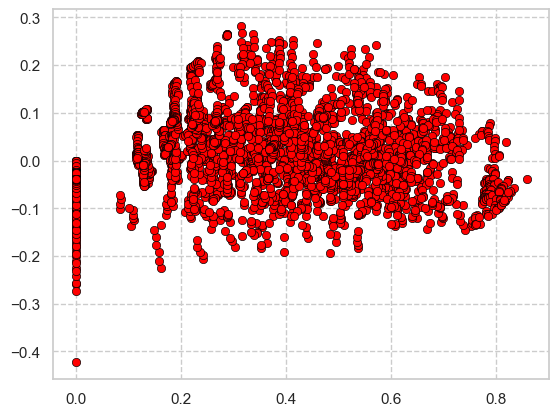

In [29]:
sns.scatterplot(x=new_target, y=val_target-pred, color='red', edgecolor='black')

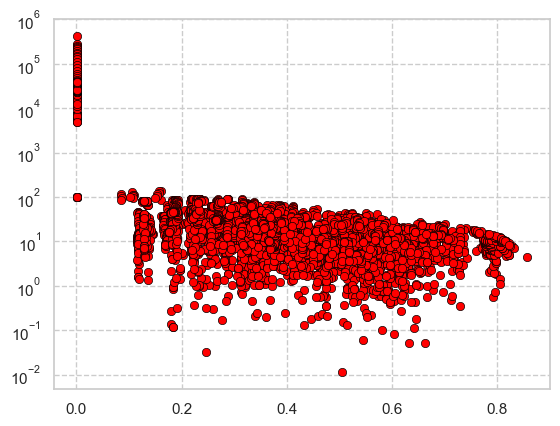

In [30]:
sns.scatterplot(x=new_target, y=error, color='red', edgecolor='black')

plt.yscale('log')

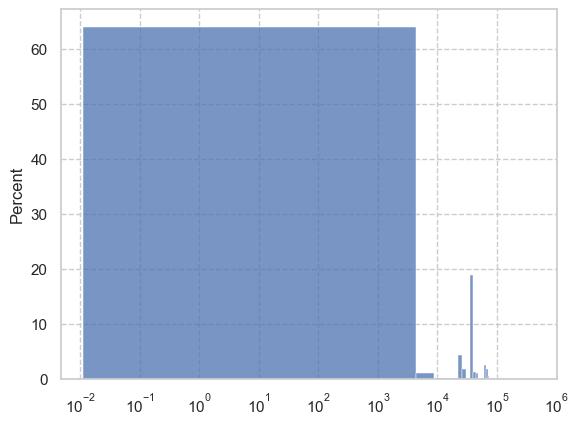

In [31]:
sns.histplot(error, stat='percent')

plt.xscale('log')